# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Volatility forecast using GARCH models 

Volatility describes uncertainities surrounding the potential price movements of financial assets, and is one of the most active research in Time Series Analysis. Volatility is not directly observable and is estimated through asset price's return fluctuations. After completing the notebook, you will be able to make sophisticated volatility forecast using GARCH and evaluate model performance. 

In this notebook, you will perform the following steps:

1. [Get the Stock data](#data)
2. [Calculate Daily Return](#return)
3. [Search Optimal Parameters](#grid_search)
4. [Forecast using GARCH model](#forecast)
5. [Model Performance](#performance)

## Step 1: Get Stock Data<a id='data'></a>

We'll continue our work with VISA stock prices.

In [2]:
from datetime import date 
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [37]:
# Busca os preços ajustados de PETR4
# Set the start and end date

ticker = 'PETR4.SA'
start_date = "2022-02-01"
end_date = "2023-02-01" #date.today().isoformat()

petr4 = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)[['Adj Close']]
data = petr4.copy()

# Transforma em retornos contínuos
#data['return'] = np.log(petr[['Adj Close']]) - np.log(petr[['Adj Close']].shift(1))
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Retira os dados faltantes
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


## Step 2: Compute Daily Price Return and Annualized Volatility<a id='return'></a>

In [42]:
# compute daily return in percentage
data['Daily Return'] = data['Adj Close'].pct_change()*100

# compute sample standard deviation of returns
data['std_dev'] = data['Daily Return'].rolling(14).std()

# annualized volatilty
data['volatility'] = data['std_dev'] * ((252)**0.5)

# drop Nan rows
data.dropna(inplace=True)

# Print the top 5 rows of the pandas dataFrame
data

,Adj Close,return,Daily Return,std_dev,volatility
Date,,,,,
2022-04-06 00:00:00-03:00,18.911306,-0.000927,-0.092612,1.686454,26.771621
2022-04-07 00:00:00-03:00,19.893105,0.050613,5.191594,2.069372,32.850255
2022-04-08 00:00:00-03:00,19.992451,0.004982,0.499400,1.883851,29.905212
2022-04-11 00:00:00-03:00,19.840508,-0.007629,-0.760003,1.898618,30.139633
2022-04-12 00:00:00-03:00,19.782066,-0.002950,-0.294555,1.894179,30.069165
...,...,...,...,...,...
2023-01-25 00:00:00-03:00,26.940001,0.012701,1.278196,2.107795,33.460212
2023-01-26 00:00:00-03:00,26.250000,-0.025946,-2.561249,2.273432,36.089617
2023-01-27 00:00:00-03:00,25.620001,-0.024293,-2.399997,2.424498,38.487706


One may use a different window for calculating sample standard deviation. It is advised to stick to 14 though! The reason being, the 'arch' package uses a similar window size of 14 days to calculate variance. You'll see the results while evaluating model performance. 

With that been said, have a look at <a href="https://www.kevinsheppard.com/">personal website</a> of the developer of this very helpful 'arch' python package. He is an Associate Professor at Oxford University who specializes in research related to volatility and uncertainty. 

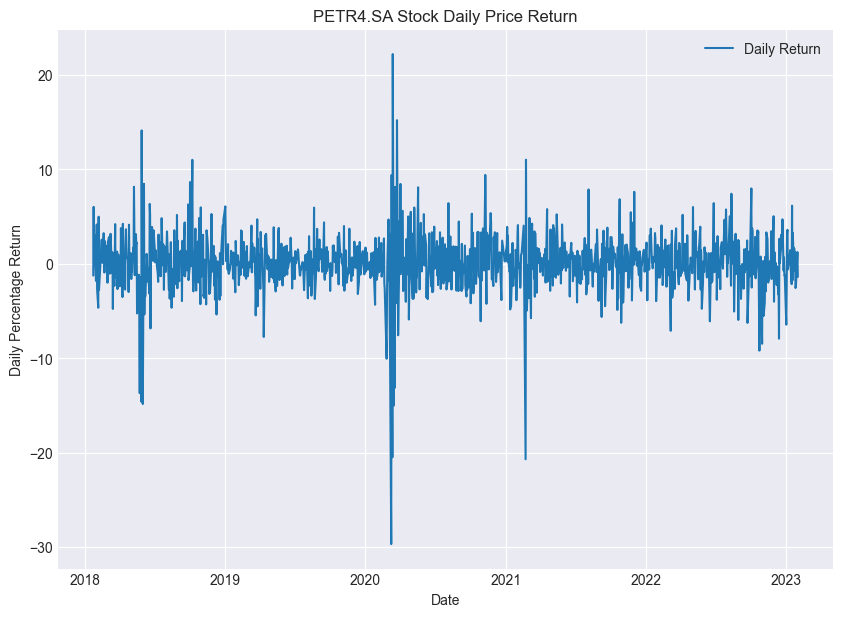

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Set the style
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('seaborn-darkgrid')

# Plot the Daily Price Return of Visa stock price 
plt.plot(data['Daily Return'])
plt.title(ticker +' Stock Daily Price Return')
plt.xlabel('Date')
plt.ylabel('Daily Percentage Return')
plt.legend(['Daily Return'])
plt.show()

The above plot looks like a stationary time series and thus we can use this data to model volatility. Recall one can check stationarity using ADF test.

### Augmented Dickey Fuller(ADF) Test

In [6]:
# Import adfuller 
from statsmodels.tsa.stattools import adfuller

# Probability value of observing the result in our data by chance
p_value = adfuller(data['Daily Return'])[1]

if p_value > 0.05:
    print("The p-value is: {p_value} > 0.05, hence time series is not stationary.".format(p_value=p_value))
else: 
    print("Time series is stationary. The p-value is: {p_value} < 0.05".format(p_value=p_value))

Time series is stationary. The p-value is: 2.1094571355385304e-20 < 0.05


ADF test confirms that Daily Return Time Series is indeed stationary.

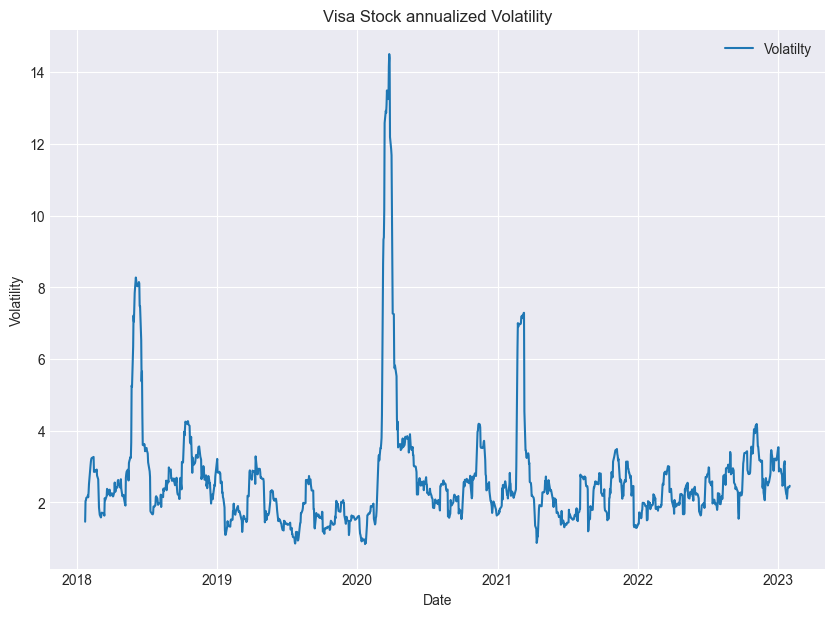

In [7]:
# Plot the Annualized Volatilty of Visa stock price 
plt.plot(data['std_dev'])
plt.title('Visa Stock annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(['Volatilty'])
plt.show()

In the above plot Note that periods of high volatility are followed by periods of low volatility. This is termed as Volatility Clustering and is commonly observed in financial asset price time series. There's a practical explanation of this behavior. The market tends to quickly respond to new information shocks with dramatic price movements. With time the effects of shocks dies and market returns to it's low volatile period. 

## Step 3: Search optimal parameters for GARCH model<a id='grid_search'></a>

The time-dependent systematic increase and decrease of volatility make modeling it a challenging task. GARCH takes this into account by introducing various model hyperparameters that can be tuned in order to make realistic volatility forecast. This includes making distribution assumptions for residuals and assumptions for mean return apart from the p,q values.

We'll grid search p,q and distribution hyperparameters while tuning GARCH model and use Akaike Information Criterion(AIC) score as the performance metric. In practice the impact of mean return model assumptions is negligible and we'll continue with the default value. 

### Performing train/test split

Before tuning hyperparameters, we'll split data into train and test set.

In [8]:
# Split data into train and test set
split = int(len(data)*0.90)
train_set, test_set = data[:split], data[split:]

### Performing Grid Search to select optimal hyperparameters

<font color='red'>Note: The below cell will take a little bit of time to run.</font>

In [9]:
# Import arch_model
from arch import arch_model

# Empty list to aic score
aic = []

# p,q values
p = range(1,6) # [1,2,3,4,5]
q = range(1,6) # [1,2,3,4,5]

# distribution values
dist = ['Normal', 't', 'skewt']

# empty list to store p,q,dist 
p_q_dist = []

# aic score for different values of p,q,dist
for i in p:
    for j in q:
        for k in dist:
            gm = arch_model(train_set['Daily Return'], vol='Garch', p=i, q=j, dist=k) # define GARCH model
            gm_fit = gm.fit(disp='off') # fit the model
            aic_temp = gm_fit.aic # get aic score
            keys_temp = (i,j,k) # p,q,dist value
            p_q_dist.append(keys_temp) # append p,q,dist 
            aic.append(aic_temp) # append aic score

In [10]:
# Store values in dictionary
aic_dict = {'p_q_dist':p_q_dist,'aic':aic}

# Import Pandas
import pandas as pd

# Create DataFrame from dictionary
df = pd.DataFrame(aic_dict)

# Return minimum AIC value with the p,q values and optimal distribution choice
df[df['aic']==df['aic'].min()]

,p_q_dist,aic
1,"(1, 1, t)",5201.543673


We got lowest AIC score for p=1, q=1 and Skewed Student's t-distribution. The distribution choice is in line with what is commonly observed in Financial World.

In [11]:
# Import arch_model
from arch import arch_model

# Define GARCH model
gm = arch_model(train_set['Daily Return'], vol='Garch', p=1, q=1, dist='skewt')

# Fit the model
gm_fit = gm.fit(disp='off')

### Standardized Residuals

We'll make use of Standardized Residuals to check the model performance. It is defined as Error Residual divided by the Conditional volatility value estimated by the model. If the GARCH model is good at modeling volatility then by definition, the standardized residuals should resemble white noise and the density plot should resemble a Normal Distribution.

In [43]:
# Obtain model estimated residuals and volatility
gm_resid = gm_fit.resid
gm_std = gm_fit.conditional_volatility * 252 ** 0.5

# Calculate the standardized residuals
gm_std_resid = gm_resid/gm_std

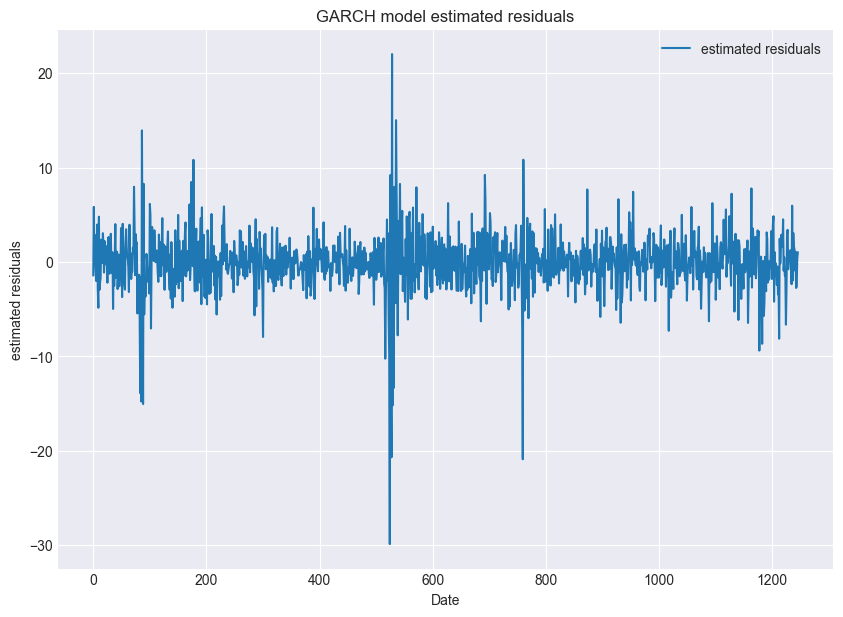

In [44]:
# Plot the model estimated residuals
plt.plot(gm_resid)
plt.title('GARCH model estimated residuals')
plt.xlabel('Date')
plt.ylabel('estimated residuals')
plt.legend(['estimated residuals'])
plt.show()

In [50]:
gm_std[530]

192.76732406200787

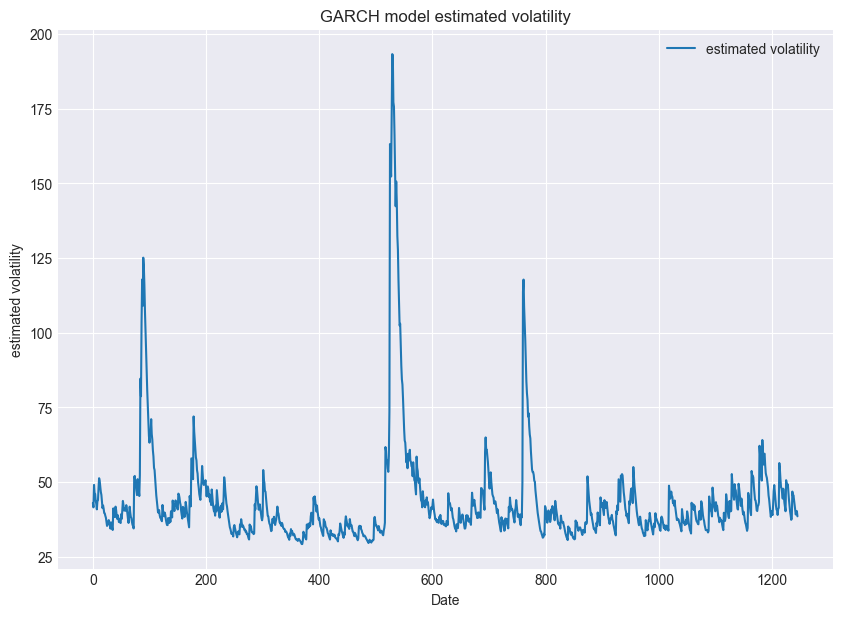

In [45]:
# Plot the model estimated volatility
plt.plot(gm_std)
plt.title('GARCH model estimated volatility')
plt.xlabel('Date')
plt.ylabel('estimated volatility')
plt.legend(['estimated volatility'])
plt.show()

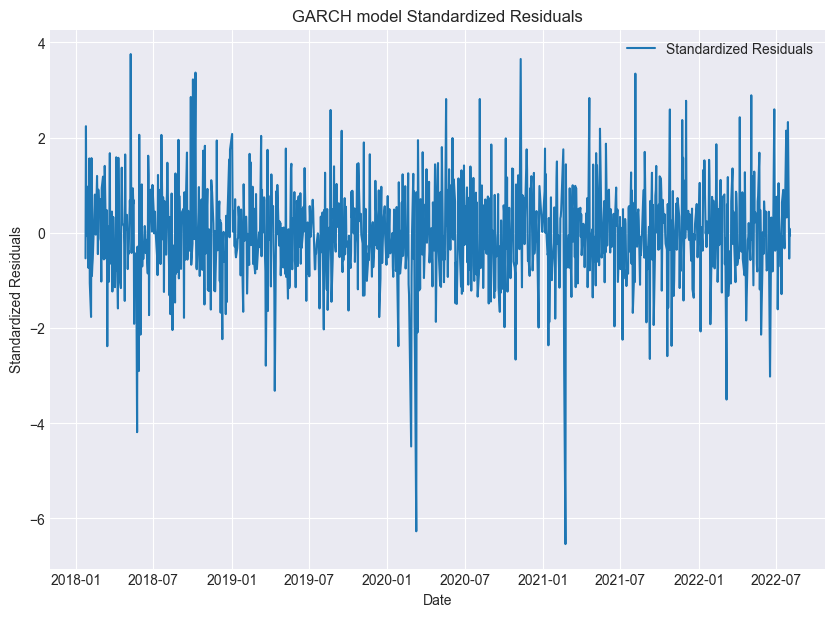

In [15]:
# Plot the Standardized Residuals
plt.plot(gm_std_resid)
plt.title('GARCH model Standardized Residuals')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend(['Standardized Residuals'])
plt.show()

This looks like white noise as we cannot observe data clustering. Thus our model can be used to make volatility forecasts.

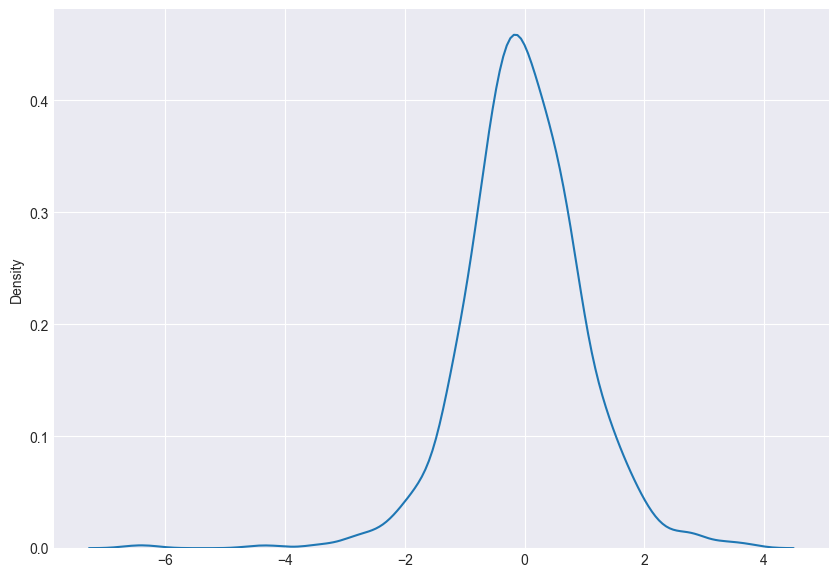

In [16]:
# Import Seaborn
import seaborn as sns

# Density plot
sns.distplot(gm_std_resid, hist=False, kde=True)
plt.show()

Above plot looks like Normal Distribution. Thus we should proceed to use this tuned model to make volatility forecast.

## Step 4: Forecast using tuned GARCH model<a id='forecast'></a>

We'll forecast using rolling window approach simillar to what followed in ARIMA notebook.

<font color='red'>Note: The below cell will take a little bit of time to run.</font>

In [17]:
# Convert pandas series to list for rolling window forecast
past = train_set['Daily Return'].tolist()

# Empty list for storing volatility predictions
predictions = []

# Perform rolling window forecast
for i in range(len(test_set)):
    gm = arch_model(past, vol='Garch', p=1, q=1, dist='skewt') # define model
    gm_fit = gm.fit(disp='off') # fit the model
    gm_fit.conditional_volatility  * 252 ** 0.5
    temp_forecast = gm_fit.forecast(horizon=1).variance # make forecast
    temp_prediction = c.iloc[-1].values[0] # store forecast volatility
    
    predictions.append((temp_prediction**0.5) * (252**0.5)) # append annualized prediction
    past.append(test_set['Daily Return'].iloc[i]) # add test value to train set

In [26]:
temp_forecast

,h.1
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1241,NaN
1242,NaN
1243,NaN
1244,NaN


In [24]:
temp_prediction**2

30.701226448659988

In [25]:
temp_prediction

5.540868744940633

In [18]:
# Predicted and actual Values
for i in range(0,20):
    print('predicted={pred}, actual={test}'.format(pred=predictions[i],test=test_set['volatility'].iloc[i]))

predicted=39.55695158116814, actual=31.129603731901177
predicted=37.85491405030861, actual=30.982960284468174
predicted=37.220508448827, actual=34.532511077950545
predicted=43.72045080979747, actual=33.66098373666253
predicted=41.872282769552335, actual=33.416586874526374
predicted=39.71020018348796, actual=37.656328493412744
predicted=39.98377334937071, actual=43.45053947183682
predicted=53.72232562104591, actual=43.96740026094197
predicted=49.9202542363616, actual=44.02080096586295
predicted=46.802702675697205, actual=43.72252281858347
predicted=45.334205695212844, actual=39.52924395083227
predicted=43.684992757182194, actual=46.85487600926119
predicted=49.57580832103178, actual=46.95785554306682
predicted=47.47826311617823, actual=47.34138671921653
predicted=47.17024350645807, actual=47.45244528498222
predicted=44.329782050295954, actual=48.49586690336476
predicted=42.33184668233167, actual=45.17588983357251
predicted=40.30456189229565, actual=45.59296180547864
predicted=40.07709280

## Step 5: Evaluate Model Performance<a id='performance'></a>

We'll calculate Error Residuals and MSE to check forecast performance.

### Residuals

In [19]:
# Create empty list
residual = []

# Append residuals
for i in range(len(test_set)):
    residual.append(predictions[i]-test_set['volatility'].iloc[i])

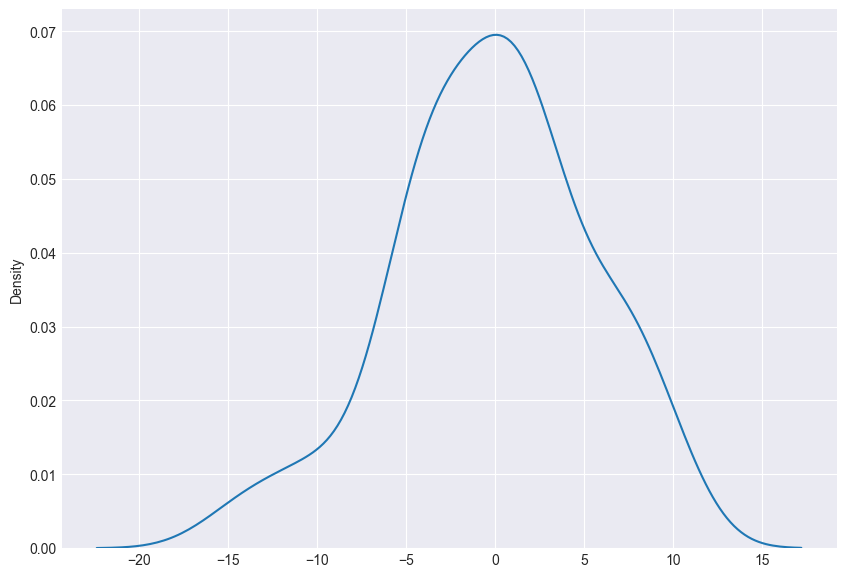

In [20]:
# Density plot
sns.distplot(residual, hist=False, kde=True)
plt.show()

Density Plot suggests that model is good at making predictions but there are some discrepancies. This is discussed at the end of notebook.

### Mean Squared Error

In [21]:
# Import MSE
from sklearn.metrics import mean_squared_error

# Calculate MSE
error_mse = mean_squared_error(test_set['volatility'], predictions)
print('Test MSE: {mse}'.format(mse=error_mse))

ModuleNotFoundError: No module named 'sklearn'

### Plotting predictions and test data 

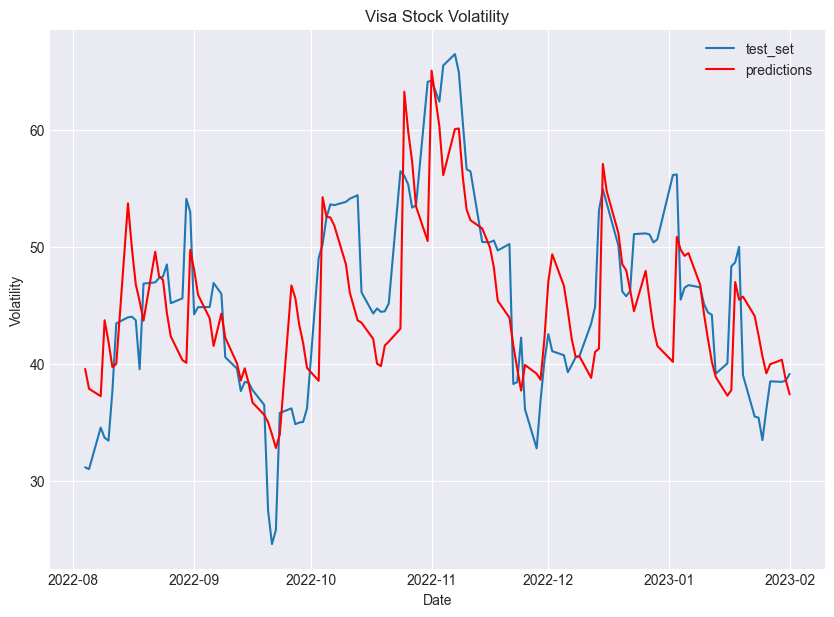

In [22]:
# Plot forecasted and actual values
plt.plot(test_set['volatility'])
plt.plot(test_set.index,predictions, color='red')
plt.title('Visa Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(['test_set','predictions'])
plt.show()

As observed through the above plot, GARCH model predictions are more than volatility calculated using a rolling window approach.

Note that GARCH uses the daily price returns as  uses Exponential Weighted Moving Average(EWMA) to make variance calculations which gives more weight to recent price data. The difference is, predictions from GARCH model are more noisy but statistically correct. 

The GARCH model surely did a great job at making volatility forecasts. Now that you know how to use GARCH model, go on and experiment with it and work on your understanding of the model.

1. Use different data sets: Try out the model on different data sets and compare model performance!
2. Asymmetric Shocks: In real financial world, asset price tends to grow slowly and take sharp dip. We can improve volatility estimates by taking this factor into account while modeling. This is implemented in 'arch' package using EGARCH and GJR-GARCH volatility models. Experiment with them and see if there is any significant increase in model performance.
3. Rolling Window Forecast: We performed an expanding rolling window forecast, where new data points are added iteratively. There's another approach where one can drop initial points while adding new data points. This is termed as Fixed Rolling Window Forecast, since the training window size is kept fixed. Try and compare the model performance.

In the next unit, you will learn about Options Trading Greeks.
<br><br>
